In [408]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, LSTM, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import numpy as np
import pandas as pd
import datetime
import os
import csv
import random
import io
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.datasets import load_gunpoint
from IPython.display import Audio

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [409]:
num_lags = 20
height = 4
width = 5
if height*width != num_lags:
    raise Exception('ERROR: dimensions do not match')

#1,2,3,6
timesteps = 6
setting = 'CNN_2D_monthly_S3_'+str(timesteps)
title = 'CNN-2D (Sigmoid, 3 Hidden Layers) Model Performance for Monthly Data: '+str(timesteps)+' Time Step'
if timesteps != 1:
    title += 's'

In [410]:
# read in data
data_type = 'average' #'min', 'max'
df = pd.read_csv('j17_monthly.csv')
pd.DataFrame.reset_index(df, drop=True)
# normalize data
def normalize(dataframe,col_name):
    sub = dataframe[col_name]
    maxx = sub.max()
    minn = sub.min()
    dataframe['Normalized Values'] = (sub - minn) / (maxx - minn)
    return dataframe['Normalized Values'],maxx,minn
normalized = pd.DataFrame()
pd.DataFrame.reset_index(normalized, drop=True)
normalized['year'] = df['year']
normalized['month'] = df['month']
normalized['level_'+data_type] = df['level_'+data_type]
normalized['Normalized Values'], maxx, minn = normalize(df,'level_'+data_type) # normalization speeds up learning and leads to faster convergence
normalized.to_csv("j17_monthly_normalized.csv") 
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,normalized,'Normalized Values','data.csv')
# prepare data
cols = []
for i in range(num_lags):
    cols.append(i+1)
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=num_lags+1)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
# reshape into 2d images
ds_x_2d = []
for j in ds_x: 
    new = []
    row = []
    val = []
    count = width
    for i in range(num_lags):
        val = [j[i]]
        #print(val)
        if count > 0:
            row.append(val)
            count-=1
        else:
            new.append(row)
            row = []
            row.append(val)
            count = width-1
    new.append(row)
    ds_x_2d.append(new)
ds_x_2d = np.array(ds_x_2d)
# ~80% training
ds_train_x = ds_x_2d[:int(0.8*len(ds_x_2d))]
ds_train_y = ds_y[:int(0.8*len(ds_y))]
# ~20% testing
ds_test_x = ds_x_2d[int(0.8*len(ds_x_2d)):]
ds_test_y = ds_y[int(0.8*len(ds_y)):]

In [411]:
epochs=125
batch_size=100
act='sigmoid'
model = Sequential()
model.add(Conv2D(5,kernel_size=(3,3),padding='same',input_shape=(height,width,1),activation=act))
#model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(5,kernel_size=(3,3),padding='same',input_shape=(height,width,1),activation=act))
#model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(5,kernel_size=(3,3),padding='same',input_shape=(height,width,1),activation=act))
#model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(25,activation=act))
model.add(Dense(25,activation=act))
#model.add(Dense(25,activation=act))
model.add(Dense(1))
#model.add(Activation('sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history_gasf = model.fit(ds_train_x, ds_train_y, epochs=epochs, verbose=3)
# apply to predictions
predictions = model.predict(ds_test_x)
result = []
for i in predictions:
  result.append(i[0])
result = np.array(result)
predicted_vals = result * (maxx-minn) + minn
true_vals = ds_test_y * (maxx-minn) + minn
diff = true_vals - predicted_vals
corr_m = np.corrcoef(predicted_vals, true_vals)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")
mse = np.square(diff).mean()
print('MSE = ' + str(mse))
mae = np.mean(np.abs(diff))
print('MAE = ' + str(mae))

Epoch 1/125
Epoch 2/125
Epoch 3/125
Epoch 4/125
Epoch 5/125
Epoch 6/125
Epoch 7/125
Epoch 8/125
Epoch 9/125
Epoch 10/125
Epoch 11/125
Epoch 12/125
Epoch 13/125
Epoch 14/125
Epoch 15/125
Epoch 16/125
Epoch 17/125
Epoch 18/125
Epoch 19/125
Epoch 20/125
Epoch 21/125
Epoch 22/125
Epoch 23/125
Epoch 24/125
Epoch 25/125
Epoch 26/125
Epoch 27/125
Epoch 28/125
Epoch 29/125
Epoch 30/125
Epoch 31/125
Epoch 32/125
Epoch 33/125
Epoch 34/125
Epoch 35/125
Epoch 36/125
Epoch 37/125
Epoch 38/125
Epoch 39/125
Epoch 40/125
Epoch 41/125
Epoch 42/125
Epoch 43/125
Epoch 44/125
Epoch 45/125
Epoch 46/125
Epoch 47/125
Epoch 48/125
Epoch 49/125
Epoch 50/125
Epoch 51/125
Epoch 52/125
Epoch 53/125
Epoch 54/125
Epoch 55/125
Epoch 56/125
Epoch 57/125
Epoch 58/125
Epoch 59/125
Epoch 60/125
Epoch 61/125
Epoch 62/125
Epoch 63/125
Epoch 64/125
Epoch 65/125
Epoch 66/125
Epoch 67/125
Epoch 68/125
Epoch 69/125
Epoch 70/125
Epoch 71/125
Epoch 72/125
Epoch 73/125
Epoch 74/125
Epoch 75/125
Epoch 76/125
Epoch 77/125
Epoch 78

In [412]:
#plt.plot(history_gasf.history['mean_squared_error'])

In [413]:
#plt.plot(history_gasf.history['mean_absolute_error'])

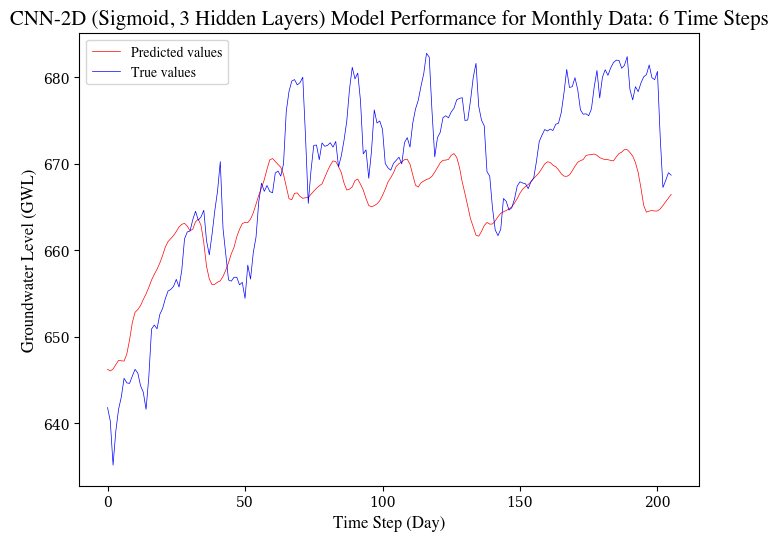

In [414]:
plt.rcParams['font.family'] = 'serif'
f='Times'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_sans-serif.png', dpi=300)
plt.show()

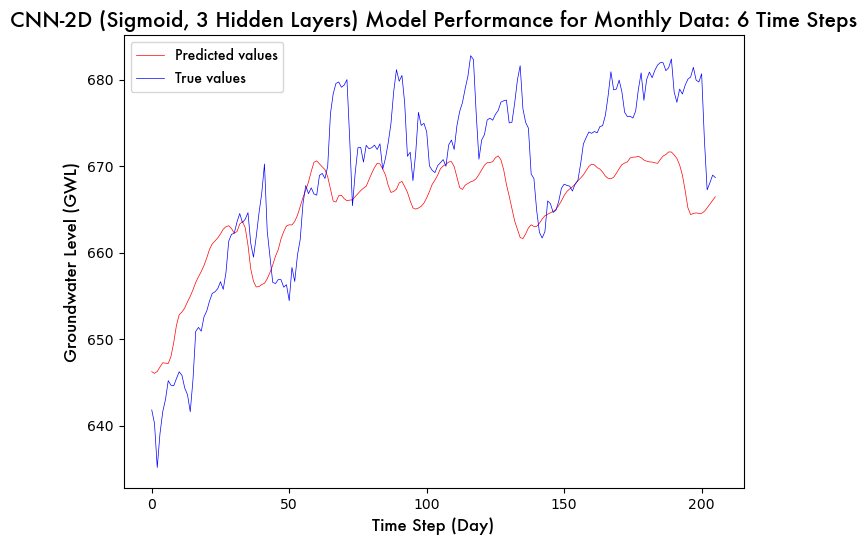

In [415]:
plt.rcParams['font.family'] = 'sans-serif'
f='Futura'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_sans-serif.png', dpi=300)
plt.show()

In [416]:
print('R2 = ' + str(r2*100) + "%")
print('MSE = ' + str(mse))
print('MAE = ' + str(mae))

R2 = 69.83133246898768%
MSE = 58.129262005486524
MAE = 6.224038203174118


In [417]:
Audio('02_01_4.wav', autoplay=True)